In [1]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout


plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

In [2]:
data= pd.read_json('tops_fashion.json')
data.head(n=5)

,sku,asin,product_type_name,formatted_price,author,color,brand,publisher,availability,reviews,large_image_url,availability_type,small_image_url,editorial_review,title,model,medium_image_url,manufacturer,editorial_reivew
0,None,B016I2TS4W,SHIRT,None,None,None,FNC7C,None,None,"[False, https://www.amazon.com/reviews/iframe?...",https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,Minions Como Superheroes Ironman Women's O Nec...,Minions Como Superheroes Ironman Long Sleeve R...,None,https://images-na.ssl-images-amazon.com/images...,None,NaN
1,None,B01N49AI08,SHIRT,None,None,None,FIG Clothing,None,None,"[False, https://www.amazon.com/reviews/iframe?...",https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,Sizing runs on the small side. FIG® recommends...,FIG Clothing Womens Izo Tunic,None,https://images-na.ssl-images-amazon.com/images...,None,NaN
2,None,B01JDPCOHO,SHIRT,None,None,None,FIG Clothing,None,None,"[False, https://www.amazon.com/reviews/iframe?...",https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,Sizing runs on the small side. FIG® recommends...,FIG Clothing Womens Won Top,None,https://images-na.ssl-images-amazon.com/images...,None,NaN
3,None,B01N19U5H5,SHIRT,None,None,None,Focal18,None,None,"[True, https://www.amazon.com/reviews/iframe?a...",https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,100% Brand New & Fashion<br> Quantity: 1 Piece...,Focal18 Sailor Collar Bubble Sleeve Blouse Shi...,None,https://images-na.ssl-images-amazon.com/images...,None,NaN
4,None,B004GSI2OS,SHIRT,$26.26,None,Onyx Black/ Stone,FeatherLite,None,Usually ships in 6-10 business days,"[False, https://www.amazon.com/reviews/iframe?...",https://images-na.ssl-images-amazon.com/images...,now,https://images-na.ssl-images-amazon.com/images...,,Featherlite Ladies' Long Sleeve Stain Resistan...,None,https://images-na.ssl-images-amazon.com/images...,None,NaN


In [3]:
data.columns

Index(['sku', 'asin', 'product_type_name', 'formatted_price', 'author',
       'color', 'brand', 'publisher', 'availability', 'reviews',
       'large_image_url', 'availability_type', 'small_image_url',
       'editorial_review', 'title', 'model', 'medium_image_url',
       'manufacturer', 'editorial_reivew'],
      dtype='object')

In [4]:
data= data[['asin', 'product_type_name', 'formatted_price','color', 'brand', 'medium_image_url','title']]
data.head(n=5)

,asin,product_type_name,formatted_price,color,brand,medium_image_url,title
0,B016I2TS4W,SHIRT,None,None,FNC7C,https://images-na.ssl-images-amazon.com/images...,Minions Como Superheroes Ironman Long Sleeve R...
1,B01N49AI08,SHIRT,None,None,FIG Clothing,https://images-na.ssl-images-amazon.com/images...,FIG Clothing Womens Izo Tunic
2,B01JDPCOHO,SHIRT,None,None,FIG Clothing,https://images-na.ssl-images-amazon.com/images...,FIG Clothing Womens Won Top
3,B01N19U5H5,SHIRT,None,None,Focal18,https://images-na.ssl-images-amazon.com/images...,Focal18 Sailor Collar Bubble Sleeve Blouse Shi...
4,B004GSI2OS,SHIRT,$26.26,Onyx Black/ Stone,FeatherLite,https://images-na.ssl-images-amazon.com/images...,Featherlite Ladies' Long Sleeve Stain Resistan...


In [5]:
print(data.shape[0], data.shape[1])

183138 7


## Cleaning Data

In [6]:
print(data['product_type_name'].describe())

count     183138
unique        72
top        SHIRT
freq      167794
Name: product_type_name, dtype: object


In [7]:
print(data['color'].describe())

count     64956
unique     7380
top       Black
freq      13207
Name: color, dtype: object


In [8]:
color_count = Counter(list(data['color']))
color_count.most_common(10)

[(None, 118182),
 ('Black', 13207),
 ('White', 8616),
 ('Blue', 3570),
 ('Red', 2289),
 ('Pink', 1842),
 ('Grey', 1499),
 ('*', 1388),
 ('Green', 1258),
 ('Multi', 1203)]

In [9]:
data =data.loc[~data['color'].isnull()]
print('Number of data points After eliminating color=NULL :', data.shape[0])

Number of data points After eliminating color=NULL : 64956


In [10]:
print(data['brand'].describe())
brand_count = Counter(list(data['brand']))
brand_count.most_common(10)

count       64843
unique       6097
top       WILLTOO
freq          183
Name: brand, dtype: object


[('WILLTOO', 183),
 ('TOOGOO(R)', 178),
 ('Sky', 161),
 ('Press Box', 145),
 ('DSQUARED2', 145),
 ('Hadari', 144),
 ('A Personal Touch', 141),
 ('Ash City', 134),
 ('SODIAL(R)', 134),
 ("Rod's", 131)]

In [11]:
print(data['formatted_price'].describe())
price_count = Counter(list(data['formatted_price']))
price_count.most_common(10)

count      28385
unique      3133
top       $19.99
freq         945
Name: formatted_price, dtype: object


[(None, 36571),
 ('$19.99', 945),
 ('$9.99', 748),
 ('$9.50', 601),
 ('$14.99', 472),
 ('$7.50', 463),
 ('$24.99', 414),
 ('$29.99', 370),
 ('$8.99', 343),
 ('$9.01', 336)]

In [12]:
data = data.loc[~data['formatted_price'].isnull()]
print('Number of data points After eliminating price=NULL :', data.shape[0])

Number of data points After eliminating price=NULL : 28385


In [13]:
data.shape[0]

28385

## Remove Duplicate

In [14]:
print(sum(data.duplicated('title')))

2325


In [15]:
sorted_data = data[data['title'].apply(lambda x: len(x.split())>4)]

In [18]:
print(sorted_data.shape[0])
data.shape[0]

27949


28385

In [17]:
sorted_data.sort_values('title', inplace=True)
sorted_data.head()

,asin,product_type_name,formatted_price,color,brand,medium_image_url,title
118987,B008D30AGK,SHIRT,$7.51,Multicolored,Out+of+Print+Clothing,https://images-na.ssl-images-amazon.com/images...,"""1984"" Retro Book Cover Women's SLim Fit T-Shi..."
78827,B003IDE8XQ,HOME,$18.99,Grey,Maggie's Organics,https://images-na.ssl-images-amazon.com/images...,"""Camisoles Grey - Medium Fair Labor, 1 pc"""
109599,B00KI3VDXM,SHIRT,$39.99,Purple,Crazy4Bling,https://images-na.ssl-images-amazon.com/images...,"""I Wanna Be Adored"" Long Sleeve Top with Shred..."
40451,B073SKNQHD,SHIRT,$24.99,Premium Heather Gray,The Workout Princess,https://images-na.ssl-images-amazon.com/images...,"""I Workout To Burn off The Crazy"", Tri Blend T..."
12050,B06WRW8RQ1,SHIRT,$9.38,Black,AJ,https://images-na.ssl-images-amazon.com/images...,"""Life is a Journey"" Self-Help DIY T-Shirt (Wom..."


In [20]:
sorted_data.to_pickle('27k_size')


In [27]:
data= pd.read_pickle('27k_size')
data.head()
#print(data.shape[0])


,asin,product_type_name,formatted_price,color,brand,medium_image_url,title
118987,B008D30AGK,SHIRT,$7.51,Multicolored,Out+of+Print+Clothing,https://images-na.ssl-images-amazon.com/images...,"""1984"" Retro Book Cover Women's SLim Fit T-Shi..."
78827,B003IDE8XQ,HOME,$18.99,Grey,Maggie's Organics,https://images-na.ssl-images-amazon.com/images...,"""Camisoles Grey - Medium Fair Labor, 1 pc"""
109599,B00KI3VDXM,SHIRT,$39.99,Purple,Crazy4Bling,https://images-na.ssl-images-amazon.com/images...,"""I Wanna Be Adored"" Long Sleeve Top with Shred..."
40451,B073SKNQHD,SHIRT,$24.99,Premium Heather Gray,The Workout Princess,https://images-na.ssl-images-amazon.com/images...,"""I Workout To Burn off The Crazy"", Tri Blend T..."
12050,B06WRW8RQ1,SHIRT,$9.38,Black,AJ,https://images-na.ssl-images-amazon.com/images...,"""Life is a Journey"" Self-Help DIY T-Shirt (Wom..."


### Removing data which has title  differ only at end

In [28]:
indices=[]
for i, row in data.iterrows():
    indices.append(i)

In [29]:
import itertools

In [32]:
i=0
j=0
stage1_asin=[]
n= data.shape[0]
while i< n and j<n :
    prev_i= i
    a= data['title'].loc[indices[i]].split()
    j= j+1
    while j < n:
        b= data['title'].loc[indices[j]].split()
        length= max(len(a), len(b))
        count=0
        for k in itertools.zip_longest(a,b): 
            if (k[0] == k[1]):
                count += 1
        if (length - count) > 2:
            stage1_asin.append(data['asin'].loc[indices[i]])

            # if the comaprision between is between num_data_points, num_data_points-1 strings and they differ in more than 2 words we include both
            if j == n-1: 
                stage1_asin.append(data['asin'].loc[indices[j]])

            i = j
            break
        else:
            j += 1
    if prev_i == i:
        break

In [33]:
data= data.loc[data['asin'].isin(stage1_asin)]
data.shape[0]

17587

## Text pre-Processing

In [35]:
nltk.download('stopwords')
#stop_words= set(stopwords.words('english'))
#print(stop_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [36]:
stop_words= set(stopwords.words('english'))
print(stop_words)

{'they', 'which', 'll', "needn't", 'both', 'won', 'doesn', 'yours', 'some', 'we', "you'd", "it's", 'whom', 'this', 'with', 'out', 'not', 'o', 'had', 'each', 'again', 'isn', 'ourselves', 's', "that'll", "she's", "mustn't", 'the', 'up', "won't", 'because', 'i', 'them', 'wasn', 'before', 'he', 'be', 'is', "don't", 'yourself', 'does', 'do', 'of', 'how', 'themselves', "you've", "shan't", 'by', 'haven', 'weren', 'are', 'if', 'only', 'and', 'been', 'should', 'such', 'against', "isn't", 'mustn', "haven't", "mightn't", 'y', "wouldn't", 'shan', 'its', 'has', 'hers', 'here', 'have', 'other', 'very', 'ma', 'above', 'ain', 'after', 'am', 'while', 'hasn', 'nor', 'herself', 'who', 'those', 'too', 'why', 'it', "couldn't", 'just', 'then', 'ours', 'me', 'from', 'their', 'for', 'him', 'most', 'she', 'you', 'can', 'down', 'couldn', 'aren', 'needn', 'own', 'or', 'her', 'between', 'below', "wasn't", 'no', 'm', 'until', 'a', 'under', 'once', 'his', 'to', "aren't", "hadn't", 'over', 're', 'an', 'myself', 'on'

In [37]:
def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        for words in total_text.split():
            # removing special chars like '"#$@!%^&*()_+-~?>< etc.
            word = ("".join(e for e in words if e.isalnum()))
            word = word.lower()
            if not word in stop_words:
                string += word + " "
        data[column][index] = string

In [43]:
start_time = time.perf_counter()
for index, row in data.iterrows():
    nlp_preprocessing(row['title'], index, 'title')
# print the time it took to preprocess whole titles 
print(time.perf_counter() - start_time, "seconds")

31.56805440000062 seconds


In [48]:
data.head()
#print(data.shape[0])

,asin,product_type_name,formatted_price,color,brand,medium_image_url,title
118987,B008D30AGK,SHIRT,$7.51,Multicolored,Out+of+Print+Clothing,https://images-na.ssl-images-amazon.com/images...,1984 retro book cover womens slim fit tshirt p...
78827,B003IDE8XQ,HOME,$18.99,Grey,Maggie's Organics,https://images-na.ssl-images-amazon.com/images...,camisoles grey medium fair labor 1 pc
109599,B00KI3VDXM,SHIRT,$39.99,Purple,Crazy4Bling,https://images-na.ssl-images-amazon.com/images...,wanna adored long sleeve top shredded shoulder...
40451,B073SKNQHD,SHIRT,$24.99,Premium Heather Gray,The Workout Princess,https://images-na.ssl-images-amazon.com/images...,workout burn crazy tri blend tank top funny wo...
12050,B06WRW8RQ1,SHIRT,$9.38,Black,AJ,https://images-na.ssl-images-amazon.com/images...,life journey selfhelp diy tshirt womensilverfe...


## stemming

In [46]:
from nltk.stem.porter import *
stemmer = PorterStemmer()
print(stemmer.stem('arguing'))
print(stemmer.stem('fishing'))


argu
fish


In [49]:
def display_img(url, ax, fig):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    # we will display it in notebook 
    plt.imshow(img)

In [50]:
def plot_heatmap(keys, values, labels, url, text):
        # keys: list of words of recommended title
        # values: len(values) ==  len(keys), values(i) represents the occurence of the word keys(i)
        # labels: len(labels) == len(keys), the values of labels depends on the model we are using
                # if model == 'bag of words': labels(i) = values(i)
                # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
                # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))
        

        gs = gridspec.GridSpec(2, 2, width_ratios=[4,1], height_ratios=[4,1]) 
        fig = plt.figure(figsize=(25,3))
        
        ax = plt.subplot(gs[0])
        
        ax = sns.heatmap(np.array([values]), annot=np.array([labels]))
        ax.set_xticklabels(keys) 
        ax.set_title(text) 
        
        
        ax = plt.subplot(gs[1])
        
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        
        
        display_img(url, ax, fig)
        
        plt.show()
    
def plot_heatmap_image(doc_id, vec1, vec2, url, text, model):

    # doc_id : index of the title1
    # vec1 : input apparels's vector
    # vec2 : recommended apparels's vector
    # url : apparels image url
    # text: title of recomonded apparel (used to keep title of image)
   


    intersection = set(vec1.keys()) & set(vec2.keys()) 

    for i in vec2:
        if i not in intersection:
            vec2[i]=0

    keys = list(vec2.keys()) 
    values = [vec2[x] for x in vec2.keys()]
    
    # labels: len(labels) == len(keys), the values of labels depends on the model we are using
        # if model == 'bag of words': labels(i) = values(i)
        # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
        # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))

    if model == 'bag_of_words':
        labels = values
    elif model == 'tfidf':
        labels = []
        for x in vec2.keys():
            if x in  tfidf_title_vectorizer.vocabulary_:
                labels.append(tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    elif model == 'idf':
        labels = []
        for x in vec2.keys():
            if x in  idf_title_vectorizer.vocabulary_:
                labels.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)

    plot_heatmap(keys, values, labels, url, text)



In [51]:
def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    return Counter(words)



def get_result(doc_id, content_a, content_b, url, model):
    text1 = content_a
    text2 = content_b
    
    vector1 = text_to_vector(text1)

    vector2 = text_to_vector(text2)

    plot_heatmap_image(doc_id, vector1, vector2, url, text2, model)

## Bag of Words on Product title

In [52]:
from sklearn.feature_extraction.text import CountVectorizer
title_vectorizer = CountVectorizer()
title_features   = title_vectorizer.fit_transform(data['title'])
title_features.get_shape()

(17587, 12922)

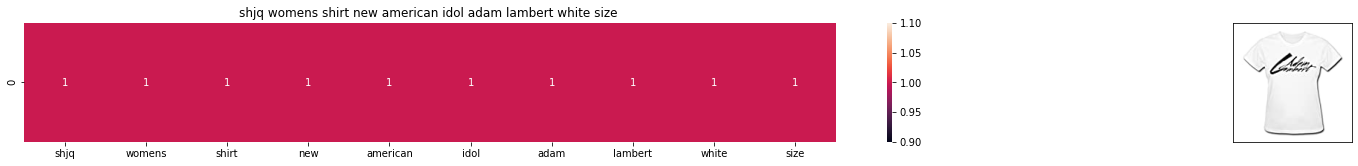

ASIN : B017L9L5VK
Brand: SHJQ
Title: shjq womens shirt new american idol adam lambert white size 
Euclidean similarity with the query image : 0.0


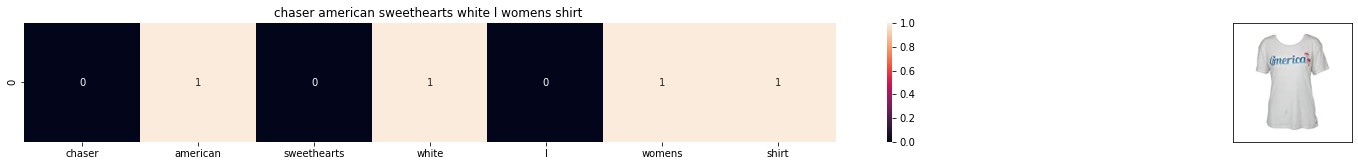

ASIN : B01LBUSWCU
Brand: Liuqiuhu
Title: chaser american sweethearts white l womens shirt 
Euclidean similarity with the query image : 2.8284271247461903


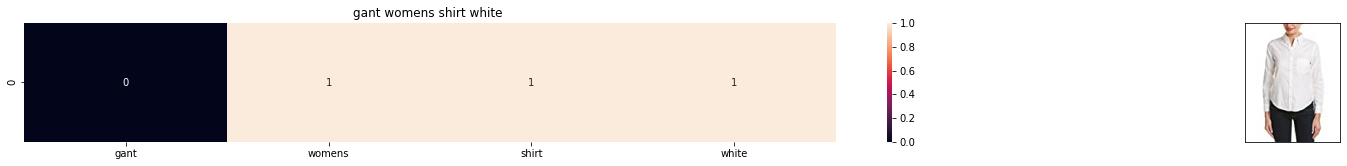

ASIN : B01N80ZGZX
Brand: GANT
Title: gant womens shirt white 
Euclidean similarity with the query image : 2.8284271247461903


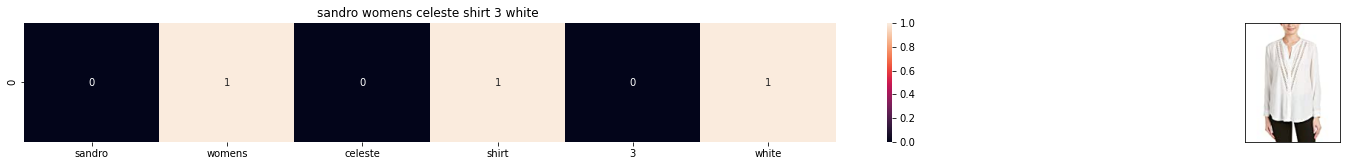

ASIN : B06XNS724Z
Brand: Sandro
Title: sandro womens celeste shirt 3 white 
Euclidean similarity with the query image : 3.0


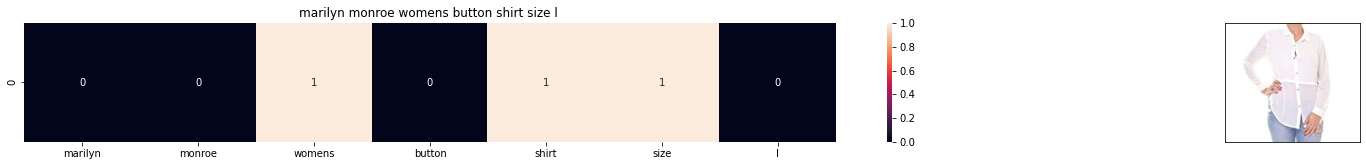

ASIN : B01MAYT4JU
Brand: Marilyn Monroe
Title: marilyn monroe womens button shirt size l 
Euclidean similarity with the query image : 3.1622776601683795


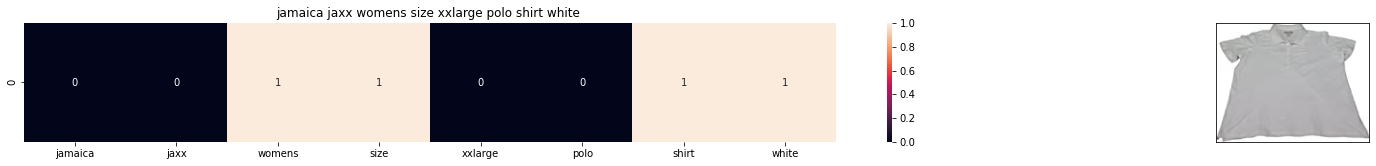

ASIN : B014E8I2WG
Brand: Jamaica Jaxx
Title: jamaica jaxx womens size xxlarge polo shirt white 
Euclidean similarity with the query image : 3.1622776601683795


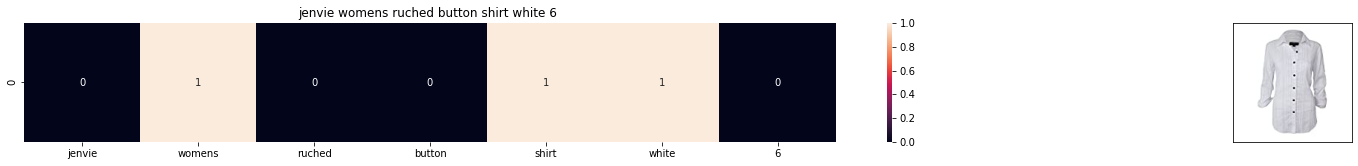

ASIN : B0746SKZ99
Brand: J'ENVIE
Title: jenvie womens ruched button shirt white 6 
Euclidean similarity with the query image : 3.1622776601683795


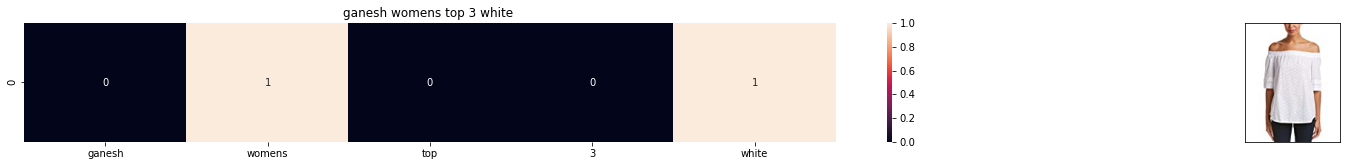

ASIN : B071VY45DD
Brand: Ganesh
Title: ganesh womens top 3 white 
Euclidean similarity with the query image : 3.1622776601683795


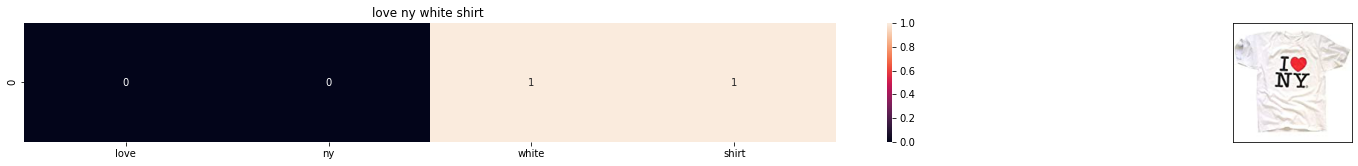

ASIN : B007N3WV6I
Brand: Forgot My Souvenirs
Title: love ny white shirt 
Euclidean similarity with the query image : 3.1622776601683795


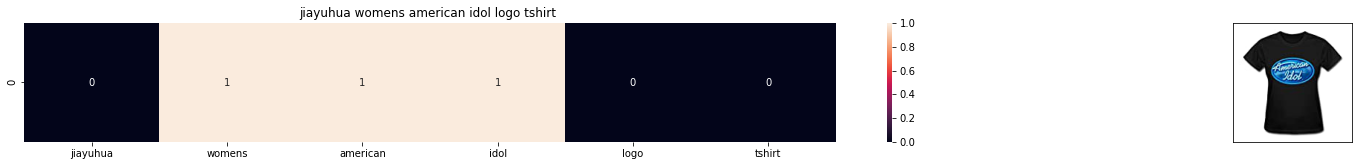

ASIN : B014XIVR5Q
Brand: JIAYUHUA
Title: jiayuhua womens american idol logo tshirt 
Euclidean similarity with the query image : 3.1622776601683795


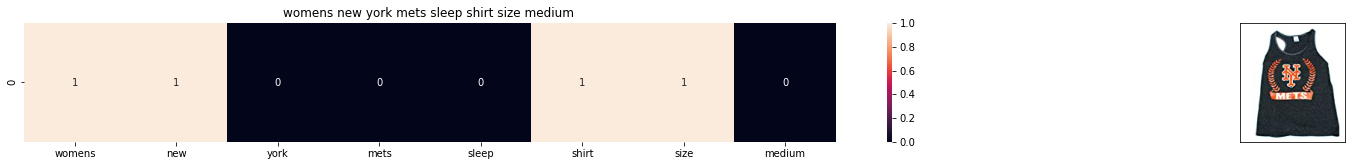

ASIN : B073RQSNF4
Brand: Campus Lifestyle
Title: womens new york mets sleep shirt size medium 
Euclidean similarity with the query image : 3.1622776601683795


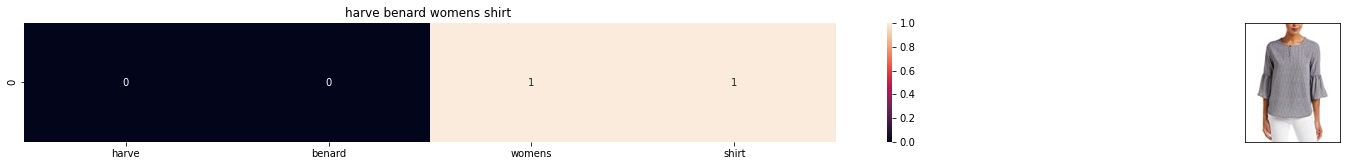

ASIN : B073JM27QH
Brand: Harve Bernard
Title: harve benard womens shirt 
Euclidean similarity with the query image : 3.1622776601683795


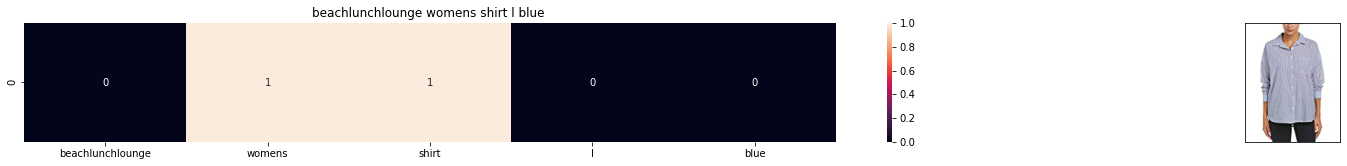

ASIN : B074SZH4JM
Brand: Beach Lunch Lounge
Title: beachlunchlounge womens shirt l blue 
Euclidean similarity with the query image : 3.1622776601683795


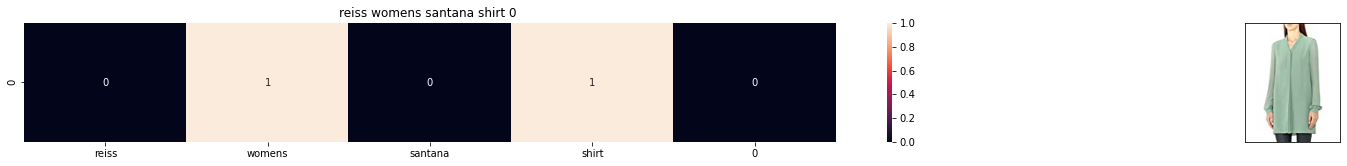

ASIN : B072FMQ7SB
Brand: Reiss
Title: reiss womens santana shirt 0 
Euclidean similarity with the query image : 3.1622776601683795


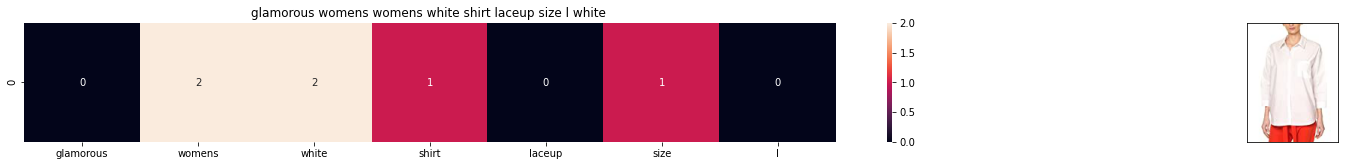

ASIN : B06Y3YJFDK
Brand: Glamorous
Title: glamorous womens womens white shirt laceup size l white 
Euclidean similarity with the query image : 3.1622776601683795


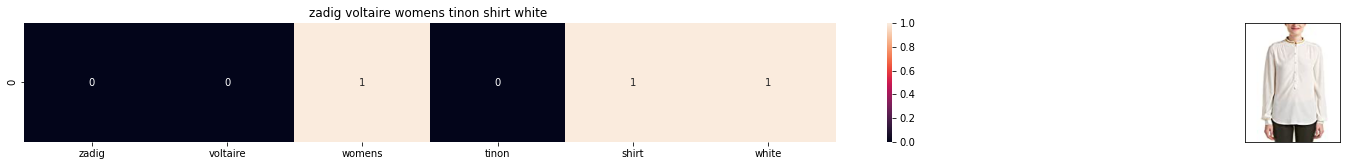

ASIN : B01MSYDSXA
Brand: Zadig & Voltaire
Title: zadig voltaire womens tinon shirt white 
Euclidean similarity with the query image : 3.1622776601683795


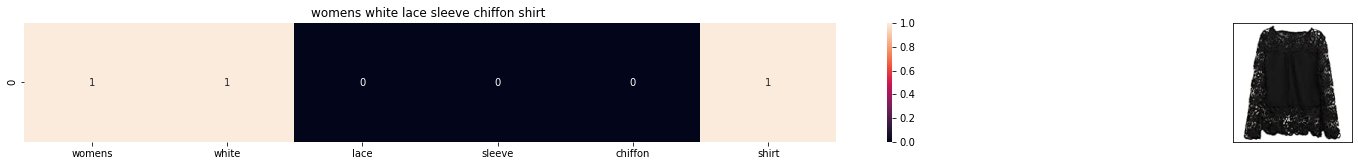

ASIN : B00XPU33FQ
Brand: Fuming
Title: womens white lace sleeve chiffon shirt 
Euclidean similarity with the query image : 3.1622776601683795


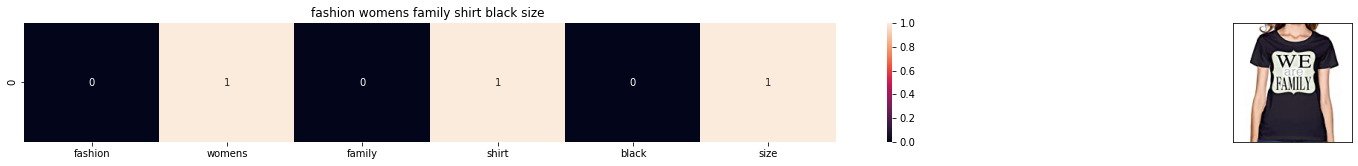

ASIN : B01IY8UJ78
Brand: Aip Yep Novelty Fashion
Title: fashion womens family shirt black size 
Euclidean similarity with the query image : 3.1622776601683795


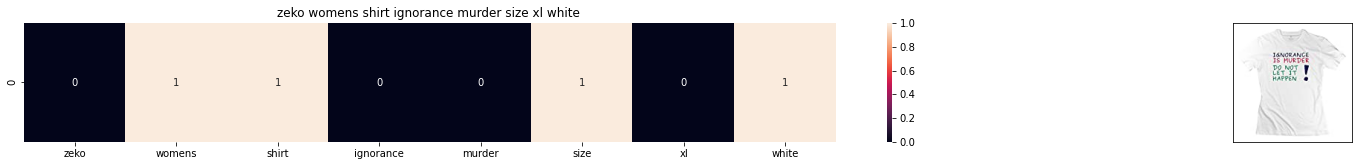

ASIN : B01269DOZU
Brand: ZEKO
Title: zeko womens shirt ignorance murder size xl white 
Euclidean similarity with the query image : 3.1622776601683795


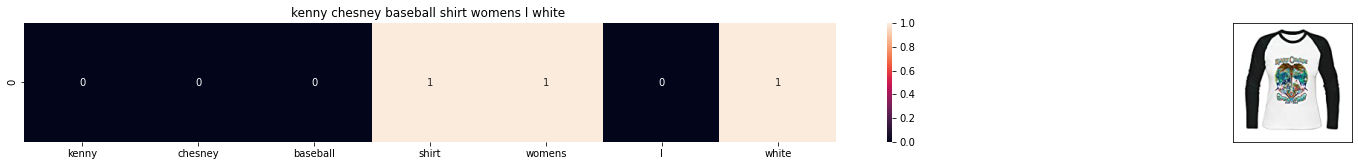

ASIN : B01MCUCWN0
Brand: Alyssa Packingham
Title: kenny chesney baseball shirt womens l white 
Euclidean similarity with the query image : 3.1622776601683795


In [53]:
def bag_of_words_model(doc_id, num_results):
    
    pairwise_dist = pairwise_distances(title_features,title_features[doc_id])
    
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]    
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    df_indices = list(data.index[indices])
    
    for i in range(0,len(indices)):
        get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'bag_of_words')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print ('Brand:', data['brand'].loc[df_indices[i]])
        print ('Title:', data['title'].loc[df_indices[i]])
        print ('Euclidean similarity with the query image :', pdists[i])
        print('='*60)

#call the bag-of-words model for a product to get similar products.
bag_of_words_model(12566, 20)

## TF-IDF based product similarity

In [54]:
tfidf_title_vectorizer = TfidfVectorizer(min_df = 0)
tfidf_title_features = tfidf_title_vectorizer.fit_transform(data['title'])

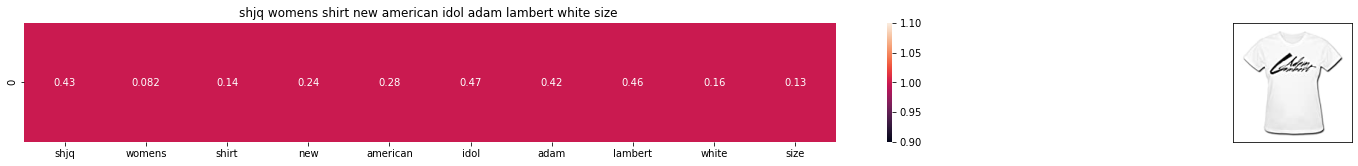

ASIN : B017L9L5VK
BRAND : SHJQ
Eucliden distance from the given image : 0.0


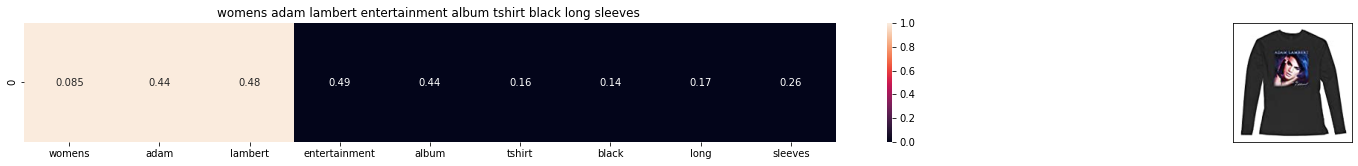

ASIN : B018XWGES8
BRAND : Tjame
Eucliden distance from the given image : 1.084395826829405


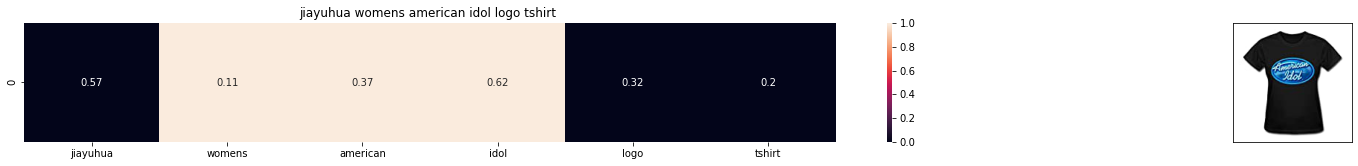

ASIN : B014XIVR5Q
BRAND : JIAYUHUA
Eucliden distance from the given image : 1.0920171210882446


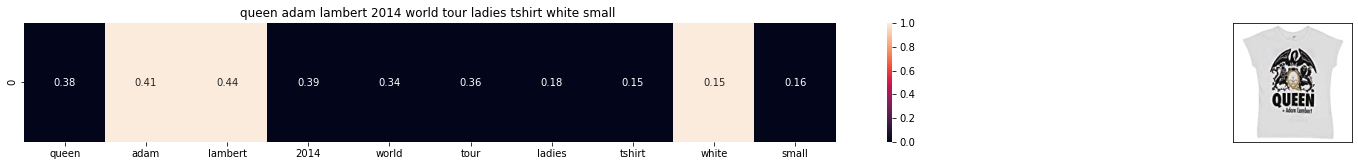

ASIN : B00WA9MXLI
BRAND : Queen
Eucliden distance from the given image : 1.097695035476702


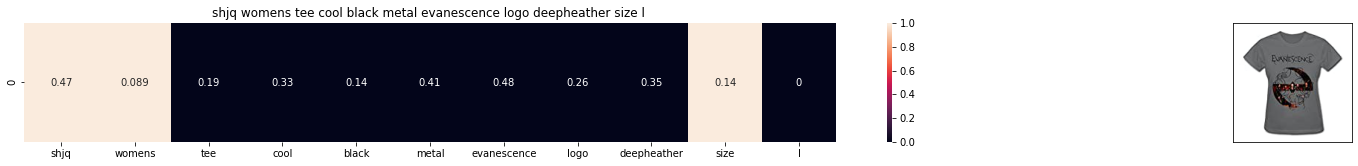

ASIN : B0162UMM16
BRAND : SHJQ
Eucliden distance from the given image : 1.2428026029573374


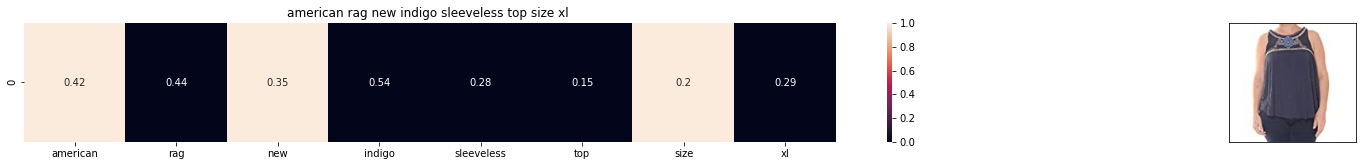

ASIN : B06XXKLGCW
BRAND : American Rag
Eucliden distance from the given image : 1.2430141968497643


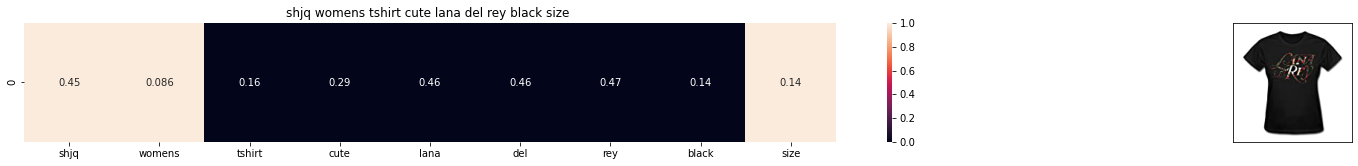

ASIN : B016UPWSAI
BRAND : SHJQ
Eucliden distance from the given image : 1.2490170215523018


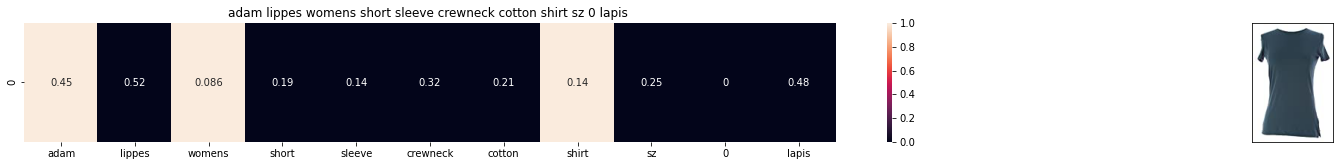

ASIN : B001IBKARI
BRAND : Adam Lippes
Eucliden distance from the given image : 1.2516137993092893


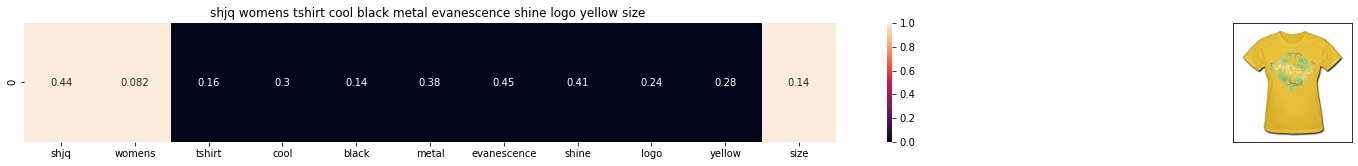

ASIN : B017LE8RMA
BRAND : SHJQ
Eucliden distance from the given image : 1.255198344294668


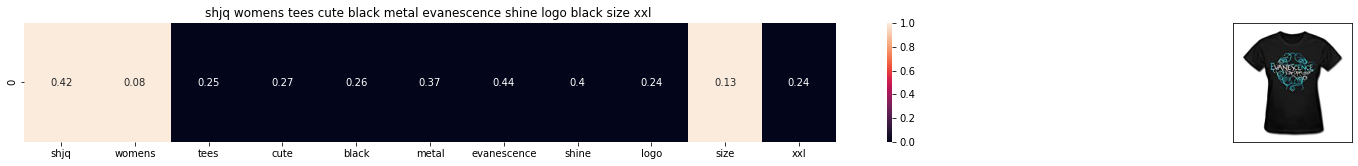

ASIN : B0162ULP1O
BRAND : SHJQ
Eucliden distance from the given image : 1.2604133513551257


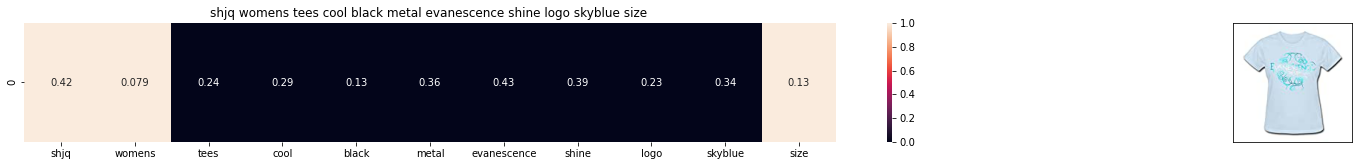

ASIN : B017LE8NFG
BRAND : SHJQ
Eucliden distance from the given image : 1.2624974332516756


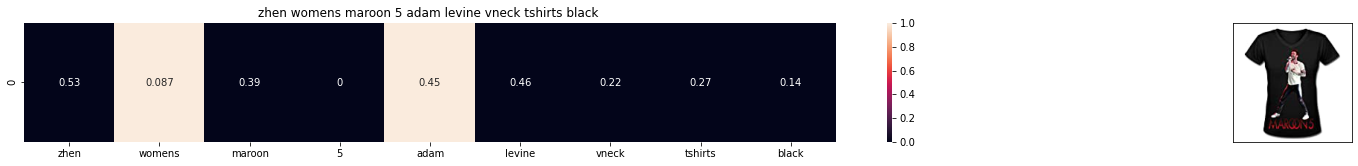

ASIN : B01L8VS6VY
BRAND : ZHEN
Eucliden distance from the given image : 1.2650170626630837


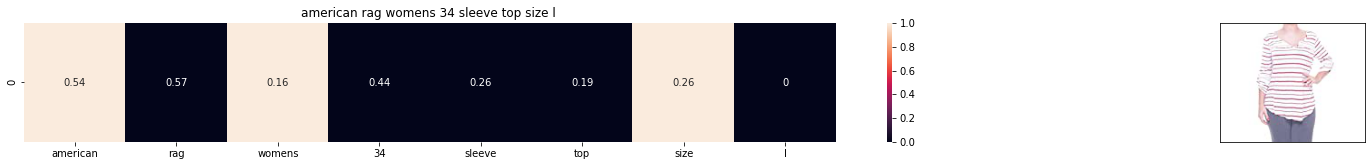

ASIN : B06XS42WGM
BRAND : American Rag
Eucliden distance from the given image : 1.2656095170760278


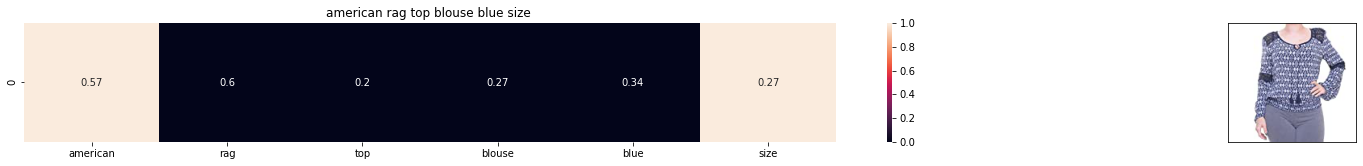

ASIN : B071HG9HHS
BRAND : American Rag
Eucliden distance from the given image : 1.2666271158584872


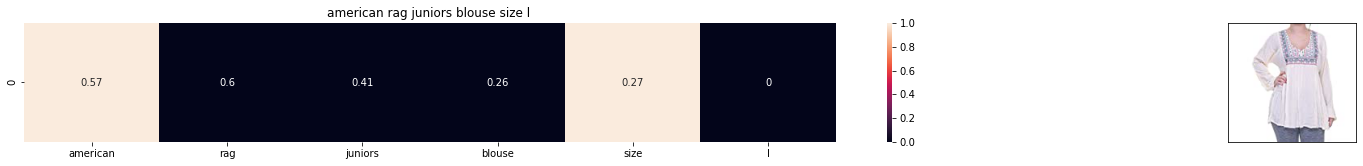

ASIN : B06XXX3D54
BRAND : American Rag
Eucliden distance from the given image : 1.267160967697374


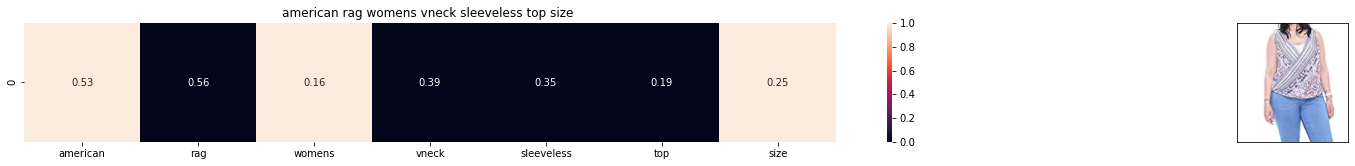

ASIN : B06XS4PM87
BRAND : American Rag
Eucliden distance from the given image : 1.267880940840348


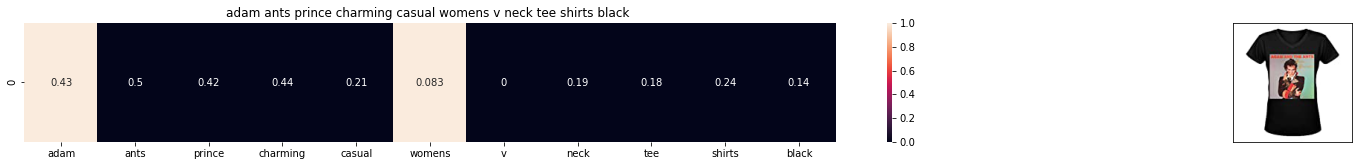

ASIN : B01I37F2YK
BRAND : Bunny Angle
Eucliden distance from the given image : 1.272427215395802


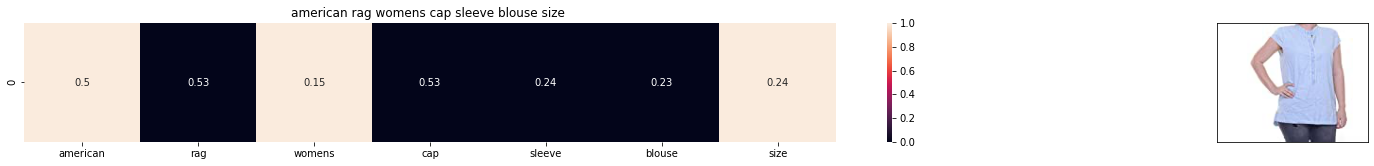

ASIN : B06XRGVRP1
BRAND : American Rag
Eucliden distance from the given image : 1.277261121905621


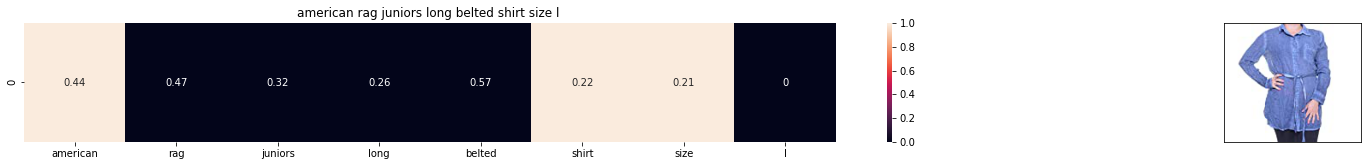

ASIN : B06XSJPPTP
BRAND : American Rag
Eucliden distance from the given image : 1.278659000775764


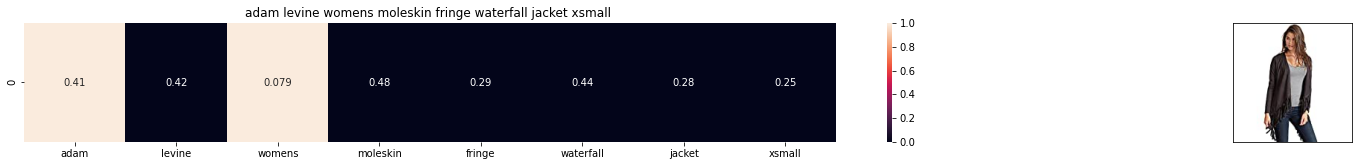

ASIN : B01N0QJZ5L
BRAND : Adam Levine
Eucliden distance from the given image : 1.2801362291046656


In [55]:
def tfidf_model(doc_id, num_results):
    
    pairwise_dist = pairwise_distances(tfidf_title_features,tfidf_title_features[doc_id])

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        get_result(indices[i], data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'tfidf')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('BRAND :',data['brand'].loc[df_indices[i]])
        print ('Eucliden distance from the given image :', pdists[i])
        print('='*125)
tfidf_model(12566, 20)
